In [10]:
"""LightGBM Implementation"""

'LightGBM Implementation'

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import  mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from utils.utils import data_subsets

In [13]:
def split_data(data, cols_pred, target):

    data_train, data_rest = train_test_split(data, test_size=0.2, random_state = 42, stratify = data['model'])
    data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12)

    data.loc[data_train.index, 'sample'] = 'train'
    data.loc[data_valid.index, 'sample'] = 'valid'
    data.loc[data_test.index, 'sample'] = 'test'

    train_mask = (data['sample'] == 'train')
    valid_mask = (data['sample'] == 'valid') 
    test_mask = (data['sample'] == 'test')

    train_weights = (data[train_mask]['depcount']*data[train_mask][target])
    train_weights = train_weights/train_weights.sum()

    valid_weights = (data[valid_mask]['depcount']*data[valid_mask][target])
    valid_weights = valid_weights/valid_weights.sum()

    test_weights = (data[test_mask]['depcount']*data[test_mask][target])
    test_weights = test_weights/test_weights.sum()

    sets = data_subsets(data_rest)

    train_ds = lgb.Dataset(data[train_mask][cols_pred], data[train_mask][target], weight = train_weights, free_raw_data=False) 
    valid_ds = lgb.Dataset(data[valid_mask][cols_pred], data[valid_mask][target], weight = valid_weights, free_raw_data=False) 
    test_ds = lgb.Dataset(data[test_mask][cols_pred], data[test_mask][target], weight = test_weights, free_raw_data=False) 
    print(cols_pred)

    return sets, train_ds, train_weights, valid_ds, valid_weights, test_ds, test_weights, data_test

def convert_to_categorical(df, columns):
    """
    Convert specified columns in a DataFrame to categorical type.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to convert

    Returns:
    - DataFrame with specified columns converted to categorical type
    """
    for column in columns:
        print(column)
        df[column] = df[column].astype('category')
    return df


In [14]:
data = pd.read_csv("data/preprocessed_data.csv")
#Add inv_dist feature
data['inv_dist']  = 1/data['dist']

In [15]:
# define list of predictors
cols_pred = ['seats', 'dist', 'inv_dist', 'model']
target = 'fuel_burn_total'

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']


print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
seats       float64
dist        float64
inv_dist    float64
dtype: object

Categorical predictors:
-----------------------
model    object
dtype: object


In [16]:
data = convert_to_categorical(data, cols_pred_cat)
sets, train_ds, train_weights, valid_ds, valid_weights, test_ds, test_weights, test = split_data(data, cols_pred, target)

model
['seats', 'dist', 'inv_dist', 'model']


In [21]:
hyperparams = {
    'task': 'train',
    'objective': 'regression',
    'categorical_feature': ['model', 'CAT'],
    'metric': 'mape',
    'max_depth': 8,
    'learning_rate':0.15,
}

# Create a dictionary to store evaluation results
evals_result = {}

model = lgb.train(params = hyperparams,
                  train_set= train_ds,
                  valid_sets=[valid_ds, test_ds, train_ds],
                  valid_names=["val", "test", "train"],
                  evals_result=evals_result,
                  num_boost_round = 2000,
                  callbacks=[lgb.early_stopping(15)]
            )

TypeError: train() got an unexpected keyword argument 'evals_result'

In [18]:
lgb.plot_metric(evals_result)

ValueError: eval results cannot be empty.

In [20]:
# Error by Haul Type

for name, set_data in zip(['Short', 'Medium', 'Medium Long', 'Long'], sets):
    set_weights = (set_data["depcount"] * set_data["fuel_burn_total"])
    set_weights = set_weights / set_weights.sum()
    test_pred = model.predict(set_data[cols_pred])
    print(f"{name} Haul")
    print(f"Test Error, MAPE: {mean_absolute_percentage_error(set_data['fuel_burn_total'], test_pred, sample_weight= set_weights)*100}%")
    

Short Haul
Test Error, MAPE: 3.873958674862306%
Medium Haul
Test Error, MAPE: 2.6280976405949485%
Medium Long Haul
Test Error, MAPE: 1.5323588146103104%
Long Haul
Test Error, MAPE: 6.790027747974289%


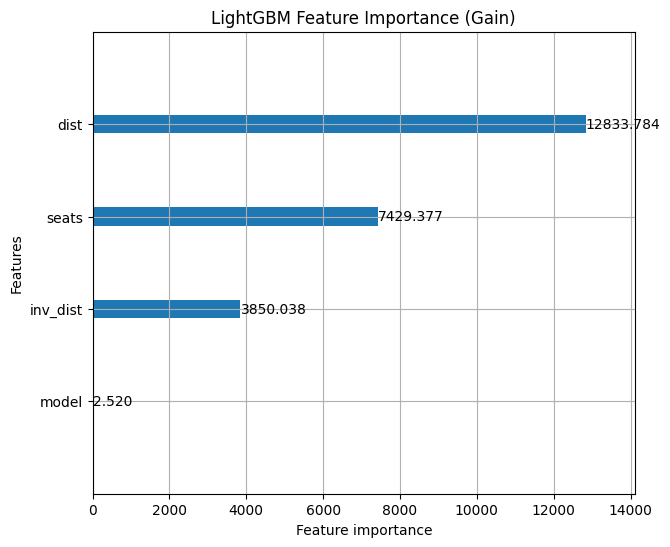

In [11]:
# lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
# plt.show()